<a href="https://colab.research.google.com/github/lisosoma/BI_ALGO/blob/main/test2_vk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 2

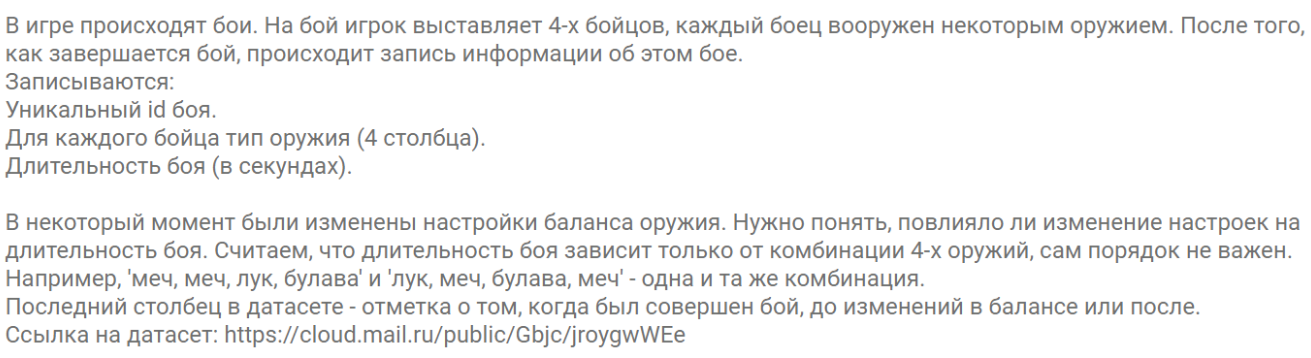

### Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from scipy.stats import f_oneway, mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

from pandas_profiling import ProfileReport

### Загрузка данных

Скачаем данные по указанной в задании ссылке и прочитаем файл `data_test.csv` в `DataFrame`. 

In [ ]:
df = pd.read_csv('data_test.csv', encoding = "cp1251")

In [ ]:
df

,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
0,103921,топор,лук,булава,лук,17.35,before
1,117214,посох,посох,лук,лук,21.84,before
2,115502,меч,посох,булава,топор,16.00,before
3,110102,булава,лук,лук,булава,17.22,before
4,104989,меч,посох,булава,посох,19.20,before
...,...,...,...,...,...,...,...
19995,108834,посох,булава,лук,посох,26.37,after
19996,119941,посох,меч,лук,посох,23.73,after
19997,112911,топор,посох,булава,топор,27.73,after
19998,111684,меч,топор,посох,меч,24.20,after


### Первичный анализ: посмотрим на зависимости

In [ ]:
 ProfileReport(df, title="Pandas Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Статистика по длительности боя

In [ ]:
print('Статистика по длительности боя до изменения баланса')
print(df[df['balance_mark'] == 'before']['len'].describe())
print()
print('Статистика по длительности боя после изменения баланса')
print(df[df['balance_mark'] == 'after']['len'].describe())

Статистика по длительности боя до изменения баланса
count    10000.000000
mean        19.973604
std          2.875324
min         15.000000
25%         17.510000
50%         19.960000
75%         22.460000
max         25.000000
Name: len, dtype: float64

Статистика по длительности боя после изменения баланса
count    10000.000000
mean        24.123115
std          3.799379
min          5.010000
25%         21.710000
50%         24.300000
75%         27.090000
max         30.000000
Name: len, dtype: float64


### Реализация некоторых функций и классов для проведения анализа

Поскольку у нас есть категориальные признаки, для дальнейшего удобства реализуем несколько фунций, которые перекодируют данные признаки в числовые или другие более удобные для дальнейшей визуализации данных объекты.

- Функция `encoder(C)` принимает на вход список, в котором хранятся названия оружий в отсортированном по алфавиту порядке. Закодируем каждое оружие бинарным вектором. Кодировка для каждого типа оружия реализована в словаре `switch`. Данная функция возвращает бинарный вектор, если значение флага `v` равняется `True`, в противном случае функция возвращает число, соответствующее бинарному вектору в десятичной системе счисления, отнормированное на максимальное значение из всех полученных бинарных векторов. (То есть диапазон возвращаемых значений  равен $(0, 1]$).

In [ ]:
class ABTesting():
    def __init__(self, X):
        self.X = X
        
        
    def CreateCombinations(self):
        self.C = []
        for index, row in self.X.iterrows():
            a = [row['unit_1'], row['unit_2'], row['unit_3'], row['unit_4']]
            a.sort()
            self.C.append(a)
        
        
    def EncoderToLabels(self):
        switch = {
            'булава' : 'б',
            'лук' : 'л',
            'меч' : 'м',
            'посох' : 'п',
            'топор' : 'т'
        }
        self.CreateCombinations()
        self.vectors = []
        for c in self.C:
            vector = switch[c[0]] + switch[c[1]] + switch[c[2]] + switch[c[3]]
            self.vectors.append(vector)
            
        self.combinations = list(set(self.vectors))
        self.combinations.sort()
        self.X['comb'] = self.vectors
        
        
    def OneHotEncoder(self):
        switch = {
            'булава' : [0, 0, 0, 0, 1],
            'лук' : [0, 0, 0, 1, 0],
            'меч' : [0, 0, 1, 0, 0],
            'посох' : [0, 1, 0, 0, 0],
            'топор' : [1, 0, 0, 0, 0]
        }
        self.CreateCombinations()
        self.binary = []
        for c in self.C:
            decimal = 0
            vector = switch[c[0]] + switch[c[1]] + switch[c[2]] + switch[c[3]]
            self.binary.append(vector)
        
        self.binary = np.array(self.binary).T
    
    
    def StatTestResults(self, testname, alpha = 0.05):
        names = {'f_oneway' : ['p-value теста ANOVA', 
                               'Проверка гипотезы о равенстве средних двух выборок: до изменения баланса и после', 
                               f_oneway],
                 'mannwhitneyu' : ['p-value теста Манна-Уитни', 
                                   'Проверка гипотезы о равенстве распределений выборок: до изменения баланса и после',
                                    mannwhitneyu]
                }
        
        fig = plt.figure(figsize = (18, 6))
        
        self.EncoderToLabels()

        plt.xlabel('комбинация оружия')
        plt.ylabel(names[testname][0])
        plt.xticks(rotation=90)
        
        i, j = 0, 0
        not_reject = []
        for c in self.combinations:
            
            X_mod = self.X[self.X['comb'] == c]
            X_before = X_mod[X_mod['balance_mark'] == 'before']['len']
            X_after = X_mod[X_mod['balance_mark'] == 'after']['len']

            # слишком маленькая выборка для проведения статистического теста
            if len(X_before) < 50 and testname == 'f_oneway': 
                continue
            else:
                pv = names[testname][2](X_before, X_after).pvalue
                if pv < alpha and i == 0:
                    plt.scatter(c, pv, color = 'red', 
                                label = f'есть основания отклонить гипотезу с уровнем значимости {alpha}')
                    i = 1
                elif pv < alpha and i == 1:
                    plt.scatter(c, pv, color = 'red')
                elif pv >= alpha and j == 0:
                    plt.scatter(c, pv, color = 'green',  
                                label = f'нет оснований отклонить гипотезу с уровнем значимости {alpha}')
                    j = 1
                    not_reject.append(c)
                else:
                    not_reject.append(c)
                    plt.scatter(c, pv, color = 'green')
                    
        plt.title(names[testname][1])
        plt.grid()
        plt.legend()
        plt.show()
        
        print('Комбинации оружия, для которых изменения не являются статистически значимыми:')
        for nr in not_reject:
            print(nr, end=' ')
        
        
    def BoxPlotsResults(self, right, left = 'аааа', all_data = False):
        if all_data:
            fig = plt.figure(figsize = (12, 6))
            ax = sns.boxplot(x="balance_mark", y="len", hue="balance_mark", data=self.X)
        else:
            X = self.X.sort_values('comb')
            fig = plt.figure(figsize = (18, 6))
            X_mod = X[(X['comb'] <= right) & (X['comb'] > left)]

            ax = sns.boxplot(x="comb", y="len", hue="balance_mark", data=X_mod)
            
            
    def MLDataSet(self):
        self.ML = self.X.loc[:, 'battle_id':'len']
        self.ML = self.ML.drop(columns=['unit_1', 'unit_2', 'unit_3', 'unit_4'])
        self.ML = self.ML.drop(columns=['battle_id'])

        self.OneHotEncoder()
        names = ['11', '12', '13', '14', '15', 
                '21', '22', '23', '24', '25',
                '31', '32', '33', '34', '35',
                '41', '42', '43', '44', '45']
        for i in range(len(names)):
            self.ML[f'encode_{names[i]}'] = self.binary[i]

In [ ]:
def plot_roc_curve(X_train, y_train, X_test, y_test):
    positive_samples = sum(1 for y in y_test if y == 0)
    models = [CatBoostClassifier(verbose = False),
              LogisticRegression(max_iter = 1000),
              RandomForestClassifier()]
    names = ['CatBoostClassifier', 'LogisticRegression', 'RandomForestClassifier']
    
    fig = plt.figure(figsize = (18, 6))
    for i, (model, name) in enumerate(zip(models, names)): 
        plt.subplot(1, 3, i+1)
        model.fit(X_train, y_train)
        p_pred = [p[0] for p in model.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        
        plt.title(name)
        plt.plot(fpr, tpr, color='red')
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.xlim(-0.01, 1.01)
        plt.ylim(-0.01, 1.01)
        y_pred = model.predict(X_test)
        print(f'F1_score для {name}: {f1_score(y_test, y_pred)}')
    plt.show()

In [ ]:
def LabelsEncode(df):
    Y = df['balance_mark']
    y = []

    for label in Y:
        if label == 'before':
            y.append(0)
        else:
            y.append(1)
        
    y = np.array(y)
    
    return y

### Проведение статистических тестов: проверка гипотезы о равенстве средних в выборках, полученных до изменения баланса и после

Проведем небольшой статистический тест. Проверим гипотезу о том, что для каждой комбинации оружия среднее значение длительности игры одинаково в боях без изменений настроек баланса оружия и в боях с изменениями настроек баланса оружия. Для этого предобработаем наши данные. Нам потребуется перекодировать комбинацию оружий в игре в число, а затем для каждой комбинации проведем ANOVA тест, позволяющий проверить гипотезу о равенстве средних в выборках.

Возьмем реализацию теста ANOVA `f_oneway` из модуля python `scipy.stats`.

In [ ]:
ds = ABTesting(df)

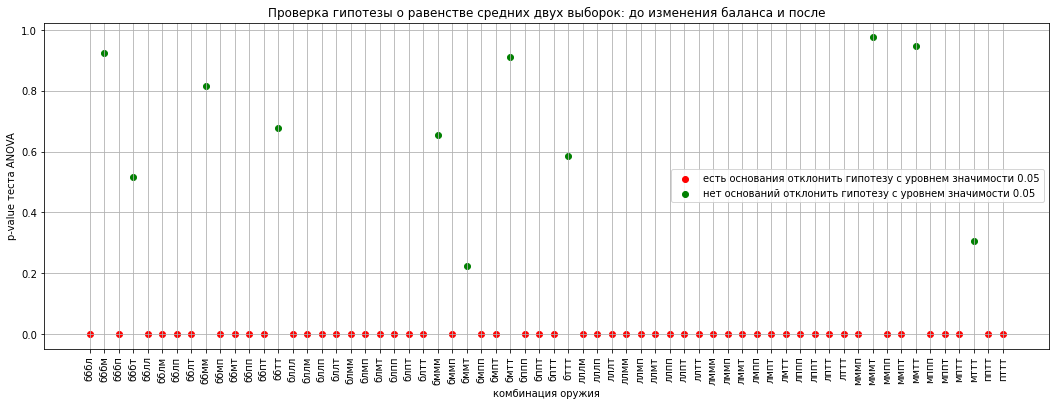

Комбинации оружия, для которых изменения не являются статистически значимыми:
бббм бббт ббмм ббтт бммм бммт бмтт бттт мммт ммтт мттт 

In [ ]:
ds.StatTestResults('f_oneway', alpha = 0.05)

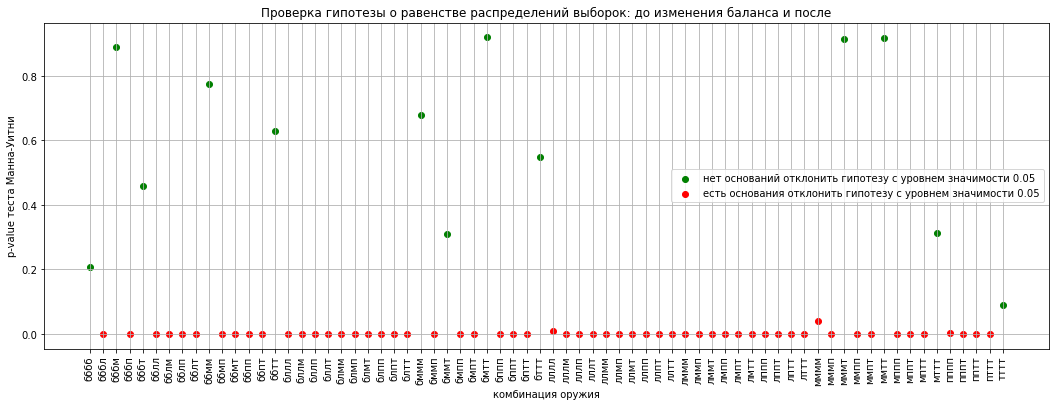

Комбинации оружия, для которых изменения не являются статистически значимыми:
бббб бббм бббт ббмм ббтт бммм бммт бмтт бттт мммт ммтт мттт тттт 

In [ ]:
ds.StatTestResults('mannwhitneyu', alpha = 0.05)

### Визуализация распределений времени длительности боя в зависимости от комбинации оружий и наличия/отсутствия изменений насроек баланса

Построим ящики с усами, чтобы посмотреть, как изменились распределения длительности боя и средние значения в них в зависимости от комбинации оружий в игре. Комбинации закодированы, как уже упоминалось ранее, первыми буквами названий оружий, то есть комбинация **лмпт** означает, что в игре были использованы **лук**, **меч**, **посох** и **топор**, комбинация **бббб** означает, что были использованы **четыре булавы**.

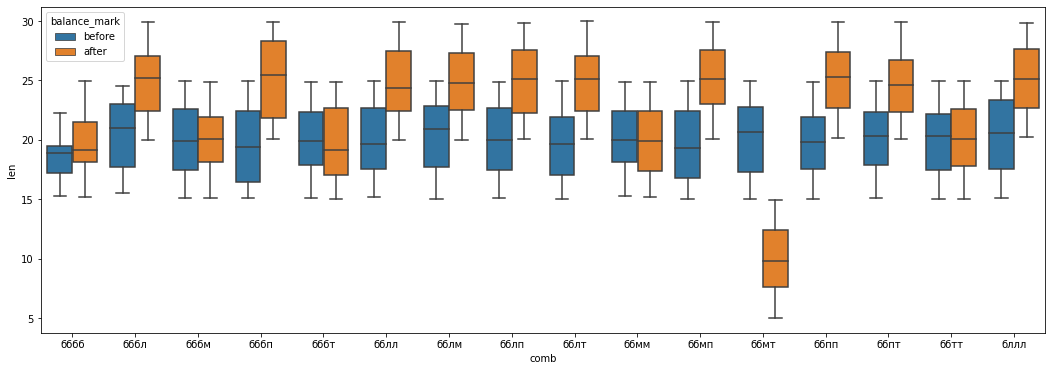

In [ ]:
ds.BoxPlotsResults('бллл')

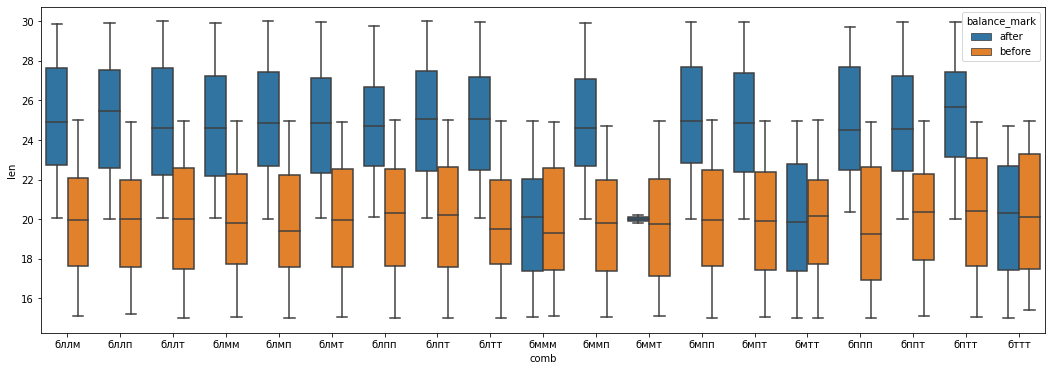

In [ ]:
ds.BoxPlotsResults('бттт', 'бллл')

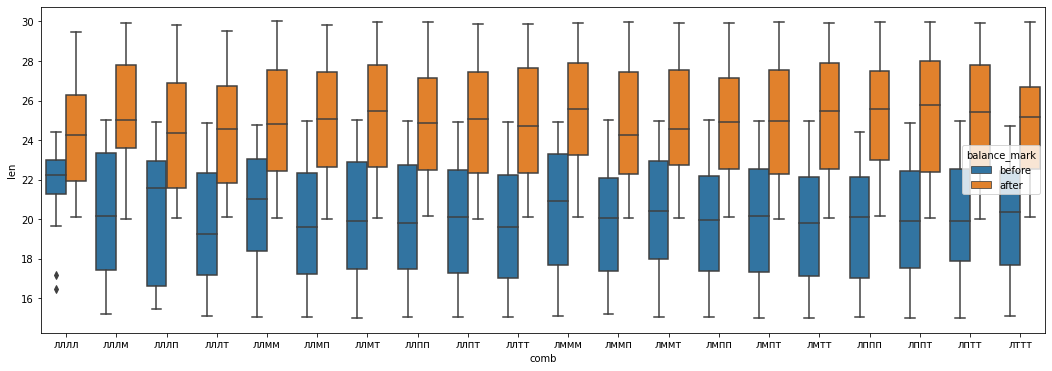

In [ ]:
ds.BoxPlotsResults('лттт', 'бттт')

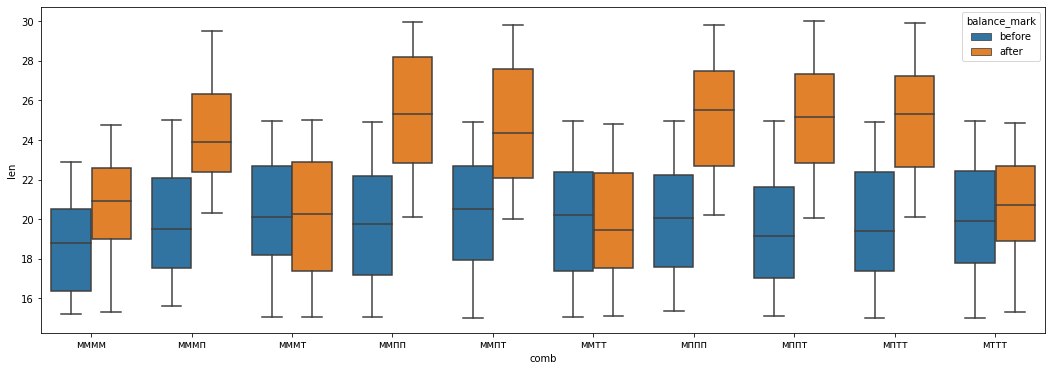

In [ ]:
ds.BoxPlotsResults('мттт', 'лттт')

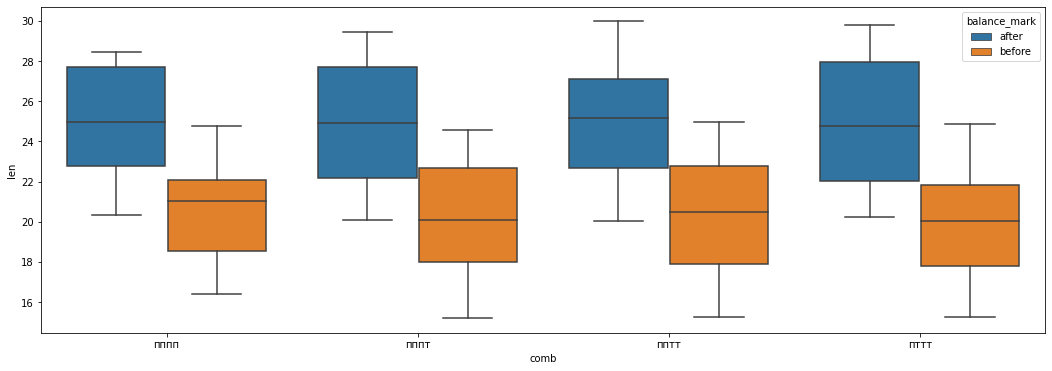

In [ ]:
ds.BoxPlotsResults('пттт', 'мттт')

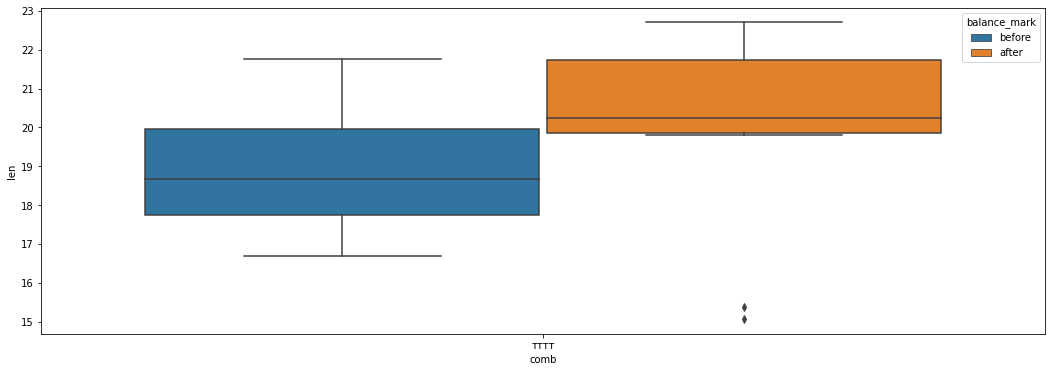

In [ ]:
ds.BoxPlotsResults('тттт', 'пттт')

Выведем также распределения длительности для всех комбинаций сразу.

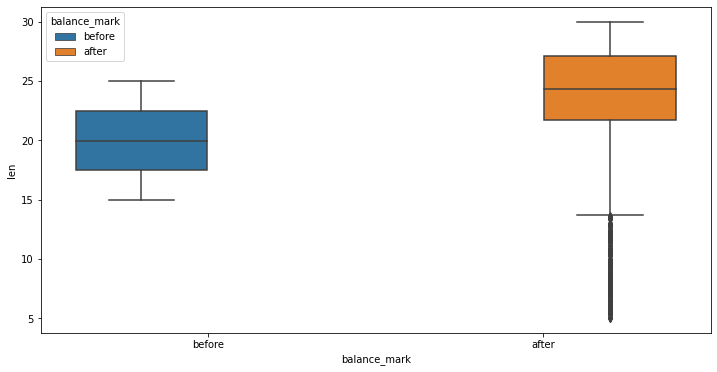

In [ ]:
ds.BoxPlotsResults('', all_data = True)

### Проведение тестов с поправками на множественную проверку гипотез

- Алгоритм Хольма

### Использования моделей машинного обучения

In [ ]:
ds.MLDataSet()
X = ds.ML
y = LabelsEncode(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

F1_score для CatBoostClassifier: 0.733862959285005
F1_score для LogisticRegression: 0.719199567333694
F1_score для RandomForestClassifier: 0.7312853498946434


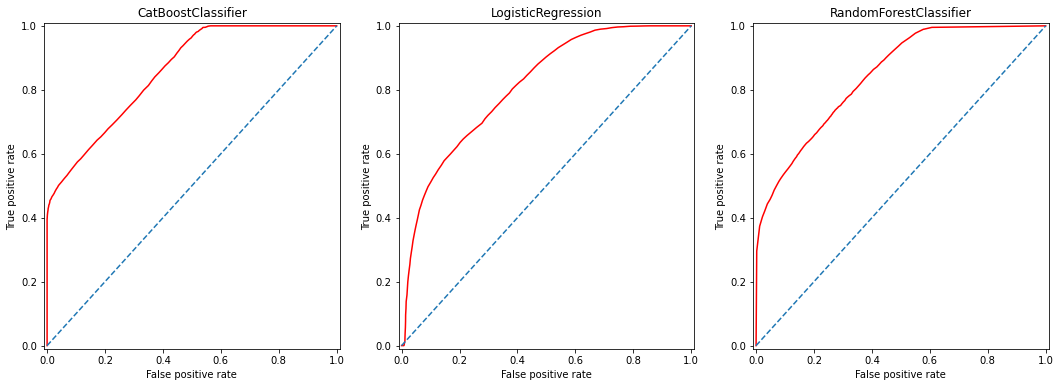

In [ ]:
plot_roc_curve(X_train, y_train, X_test, y_test)

# TODO

- провести полноценное А/Б-тестирование
- алгоритм хольма

## Выводы

- Судя по первичному анализу из `Pandas Profile Report` существует зависимость между признаками `len` и `balance_mark`, а также `len` слабо коррелирует с `unit_1` - `unit_4`.

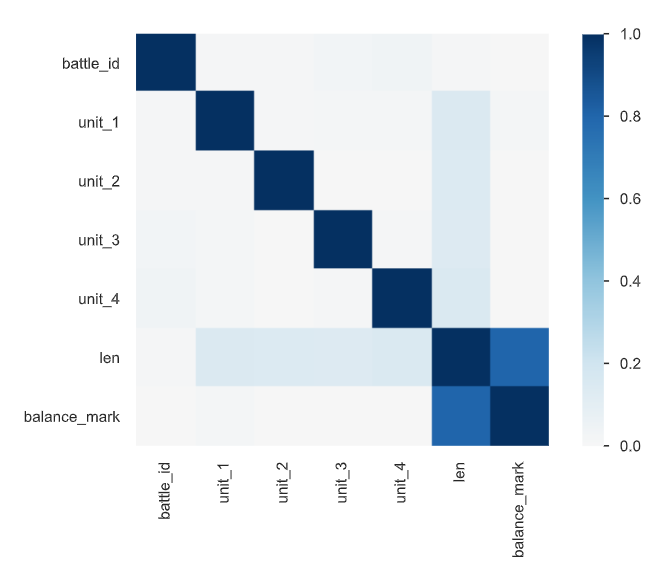

- Можно увидеть, что средние значения для всех комбинаций оружия до изменения настроек в балансе и после отличаются: до изменения настроек среднее равнялось $19.97$ секунд, после -- $24.12$ секунд. Можно предположить, что изменение насроек в балансе увеличивавет длительность боя, однако дальнейший анализ показал, что это не всегда так.

- После проведения ряда статистических тестов (T-теста и U-теста) без поправок на множественные сравнения выяснилось, что действительно изменились как средние значения длительности боя для большинства комбинаций, так и сами распределения времени боя для большинства комбинаций. 

- Комбинации оружия, для которых p-value было больше принятого уровня значимости ($\alpha = 0.05$):
    - 4 булавы
    - 3 булавы, 1 меч
    - 3 булавы, 1 топор
    - 2 булавы, 2 меча
    - 2 булавы, 2 топора
    - 1 блуава, 3 меча
    - 1 булава, 2 меча, 1 топор
    - 1 булава, 1 меч, 2 топора
    - 1 булава, 3 топора
    - 3 меча, 1 топор
    - 2 меча, 2 топора
    - 1 меч, 3 топора
    - 4 топора
    
- Можно заметить, что в этих комбинациях не встречается оружие **лук**. Можно предположить, что изменение настроек баланса для лука сильно повлияло на длительность боя.

- Далее для каждой комбинации оружия из датасета были построены ящики с усами. По ним уже отчетливо видно, что распределения длительности боя после изменения настроек баланса действительно сильно изменились. Для **посчитать проценты**% комбинаций медианнные значения длительности боя уменьшились, для **посчитать проценты**% увеличелись, и лишь для **посчитать проценты**% остались без статистически значимых изменений.

- Также были построены классификаторы, `f1_score` которых показывает достаточно высокое значение, то есть данные можно хорошо классифицировать, учитывая длительность боя и комбинации оружия (которые были перекодированы с помощью *one-hot-encoding*). Исходя из этого также можно сказать, что после изменений настроек в балансе произошли изменения в длительности боя.